In [13]:
import blackjack
import cliffwalking
import frozenlake

import argparse
import os

import gymnasium as gym
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

from tianshou.data import (
    Collector,
    CollectStats,
    PrioritizedVectorReplayBuffer,
    ReplayBuffer,
    VectorReplayBuffer,
)
from tianshou.env import DummyVectorEnv
from tianshou.policy.modelfree.iqn import IQNPolicy
import tianshou.policy.modelfree.iqn as iqn
from tianshou.policy.base import BasePolicy
from tianshou.trainer import OffpolicyTrainer
from tianshou.utils import TensorboardLogger
from tianshou.utils.net.common import Net
from tianshou.utils.net.discrete import ImplicitQuantileNetwork
from tianshou.utils.space_info import SpaceInfo

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
envs_names = ["CustomBlackjack-v0", "CustomCliffWalking-v0", "FrozenLakeCustom-v0"]
reward_threshholds = [500, 500, 500,500]

def get_args(env_idx) -> argparse.Namespace:
    parser = argparse.ArgumentParser()
    
    parser.add_argument("--task", type=str, default=envs_names[env_idx])
    parser.add_argument("--reward-threshold", type=float, default=reward_threshholds[env_idx])
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--eps-test", type=float, default=0.05)
    parser.add_argument("--eps-train", type=float, default=0.1)
    parser.add_argument("--buffer-size", type=int, default=20000)
    parser.add_argument("--lr", type=float, default=3e-3)
    parser.add_argument("--gamma", type=float, default=0.9)
    parser.add_argument("--sample-size", type=int, default=32)
    parser.add_argument("--online-sample-size", type=int, default=8)
    parser.add_argument("--target-sample-size", type=int, default=8)
    parser.add_argument("--num-cosines", type=int, default=64)
    parser.add_argument("--n-step", type=int, default=3)
    parser.add_argument("--target-update-freq", type=int, default=320)
    parser.add_argument("--epoch", type=int, default=10)
    parser.add_argument("--step-per-epoch", type=int, default=2000)
    parser.add_argument("--step-per-collect", type=int, default=10)
    parser.add_argument("--update-per-step", type=float, default=0.1)
    parser.add_argument("--batch-size", type=int, default=64)
    parser.add_argument("--hidden-sizes", type=int, nargs="*", default=[64, 64, 64])
    parser.add_argument("--training-num", type=int, default=10)
    parser.add_argument("--test-num", type=int, default=100)
    parser.add_argument("--logdir", type=str, default="log")
    parser.add_argument("--render", type=float, default=0.0)
    parser.add_argument("--prioritized-replay", action="store_true", default=False)
    parser.add_argument("--alpha", type=float, default=0.6)
    parser.add_argument("--beta", type=float, default=0.4)
    parser.add_argument(
        "--device",
        type=str,
        default="cuda" if torch.cuda.is_available() else "cpu",
    )
    return parser.parse_known_args()[0]


In [15]:
def train(env_idx):
    iqn.RESULTS = []
    args: argparse.Namespace = get_args(env_idx)
    env = gym.make(args.task)
    space_info = SpaceInfo.from_env(env)
    assert isinstance(env.action_space, gym.spaces.Discrete)
    args.state_shape = space_info.observation_info.obs_shape
    args.action_shape = space_info.action_info.action_shape
    if args.reward_threshold is None:
        default_reward_threshold = {"BairdsCounterexample-v0": 195}
        args.reward_threshold = default_reward_threshold.get(
            args.task,
            env.spec.reward_threshold if env.spec else None,
        )
    # train_envs = gym.make(args.task)
    # you can also use tianshou.env.SubprocVectorEnv
    train_envs = DummyVectorEnv([lambda: gym.make(args.task) for _ in range(args.training_num)])
    # test_envs = gym.make(args.task)
    test_envs = DummyVectorEnv([lambda: gym.make(args.task) for _ in range(args.test_num)])
    # seed
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    train_envs.seed(args.seed)
    test_envs.seed(args.seed)
    # model
    feature_net = Net(
        args.state_shape,
        args.hidden_sizes[-1],
        hidden_sizes=args.hidden_sizes[:-1],
        device=args.device,
        softmax=False,
    )
    net = ImplicitQuantileNetwork(
        feature_net,
        args.action_shape,
        num_cosines=args.num_cosines,
        device=args.device,
    )
    optim = torch.optim.Adam(net.parameters(), lr=args.lr)
    policy: IQNPolicy = IQNPolicy(
    model=net,
    optim=optim,
    action_space=env.action_space,
    discount_factor=args.gamma,
    sample_size=args.sample_size,
    online_sample_size=args.online_sample_size,
    target_sample_size=args.target_sample_size,
    estimation_step=args.n_step,
    target_update_freq=args.target_update_freq,
    ).to(args.device)
    # buffer
    buf: ReplayBuffer
    if args.prioritized_replay:
        buf = PrioritizedVectorReplayBuffer(
            args.buffer_size,
            buffer_num=len(train_envs),
            alpha=args.alpha,
            beta=args.beta,
        )
    else:
        buf = VectorReplayBuffer(args.buffer_size, buffer_num=len(train_envs))
    # collector
    train_collector = Collector[CollectStats](policy, train_envs, buf, exploration_noise=True)
    test_collector = Collector[CollectStats](policy, test_envs, exploration_noise=True)
    # policy.set_eps(1)
    train_collector.reset()
    train_collector.collect(n_step=args.batch_size * args.training_num)
    # log
    log_path = os.path.join(args.logdir, args.task, "iqn")
    writer = SummaryWriter(log_path)
    logger = TensorboardLogger(writer)
    def stop_fn(mean_rewards: float) -> bool:
        return mean_rewards >= args.reward_threshold
    def train_fn(epoch: int, env_step: int) -> None:
        # eps annnealing, just a demo
        if env_step <= 10000:
            policy.set_eps(args.eps_train)
        elif env_step <= 50000:
            eps = args.eps_train - (env_step - 10000) / 40000 * (0.9 * args.eps_train)
            policy.set_eps(eps)
        else:
            policy.set_eps(0.1 * args.eps_train)
    def test_fn(epoch: int, env_step: int | None) -> None:
        policy.set_eps(args.eps_test)
     # trainer
    result = OffpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=args.epoch,
        step_per_epoch=args.step_per_epoch,
        step_per_collect=args.step_per_collect,
        episode_per_test=args.test_num,
        batch_size=args.batch_size,
        train_fn=train_fn,
        test_fn=test_fn,
        stop_fn=stop_fn,
        logger=logger,
        update_per_step=args.update_per_step,
    ).run()
    return iqn.RESULTS.copy()


In [16]:
results = []
for i in range(len(envs_names)):
    print("Started training: ", envs_names[i])
    results.append(train(i))
    print("Finished training")

Started training:  CustomBlackjack-v0


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #1: test_reward: -0.100000 ± 0.964365, best_reward: -0.100000 ± 0.964365 in #1


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #2: 2001it [00:05, 396.18it/s, env_episode=3092, env_step=4000, gradient_step=400, len=1, n/ep=6, n/st=10, rew=-0.67]                          


Epoch #2: test_reward: -0.040000 ± 0.968710, best_reward: -0.040000 ± 0.968710 in #2


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #3: 2001it [00:05, 336.37it/s, env_episode=4564, env_step=6000, gradient_step=600, len=1, n/ep=9, n/st=10, rew=0.56]                          


Epoch #3: test_reward: -0.130000 ± 0.945040, best_reward: -0.040000 ± 0.968710 in #2


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #4: 2001it [00:06, 292.79it/s, env_episode=5980, env_step=8000, gradient_step=800, len=1, n/ep=8, n/st=10, rew=-0.25]                          


Epoch #4: test_reward: -0.320000 ± 0.926067, best_reward: -0.040000 ± 0.968710 in #2


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #5: 2001it [00:07, 261.79it/s, env_episode=7410, env_step=10000, gradient_step=1000, len=1, n/ep=9, n/st=10, rew=-0.11]                          


Epoch #5: test_reward: -0.110000 ± 0.978724, best_reward: -0.040000 ± 0.968710 in #2


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #6: test_reward: -0.180000 ± 0.952680, best_reward: -0.040000 ± 0.968710 in #2


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #7: test_reward: -0.160000 ± 0.976934, best_reward: -0.040000 ± 0.968710 in #2


Epoch #8: 2001it [00:09, 221.75it/s, env_episode=11732, env_step=16000, gradient_step=1600, len=1, n/ep=8, n/st=10, rew=-0.62]                          


Epoch #8: test_reward: -0.050000 ± 0.931397, best_reward: -0.040000 ± 0.968710 in #2


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #9: 2001it [00:08, 223.58it/s, env_episode=13168, env_step=18000, gradient_step=1800, len=1, n/ep=8, n/st=10, rew=0.50]                          


Epoch #9: test_reward: -0.100000 ± 0.953939, best_reward: -0.040000 ± 0.968710 in #2


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #10: 2001it [00:09, 208.51it/s, env_episode=14591, env_step=20000, gradient_step=2000, len=1, n/ep=9, n/st=10, rew=-0.56]                          


Epoch #10: test_reward: -0.150000 ± 0.952628, best_reward: -0.040000 ± 0.968710 in #2
Finished training
Started training:  CustomCliffWalking-v0


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #1: test_reward: -1140.530000 ± 225.952183, best_reward: -1135.580000 ± 234.352051 in #0


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #2: test_reward: -512.870000 ± 38.736715, best_reward: -512.870000 ± 38.736715 in #2


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #3: test_reward: -500.990000 ± 9.850376, best_reward: -500.990000 ± 9.850376 in #3


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #4: test_reward: -501.980000 ± 13.860000, best_reward: -500.990000 ± 9.850376 in #3


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #5: test_reward: -500.000000 ± 0.000000, best_reward: -500.000000 ± 0.000000 in #5


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #6: 2001it [00:06, 319.69it/s, env_episode=20, env_step=12000, gradient_step=1200, len=500, n/ep=0, n/st=10, rew=-589.10]                          


Epoch #6: test_reward: -500.990000 ± 9.850376, best_reward: -500.000000 ± 0.000000 in #5


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #7: 2001it [00:06, 293.02it/s, env_episode=20, env_step=14000, gradient_step=1400, len=500, n/ep=0, n/st=10, rew=-589.10]                          


Epoch #7: test_reward: -502.970000 ± 16.888135, best_reward: -500.000000 ± 0.000000 in #5


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #8: 2001it [00:07, 268.57it/s, env_episode=30, env_step=16000, gradient_step=1600, len=500, n/ep=0, n/st=10, rew=-500.00]                          


Epoch #8: test_reward: -501.980000 ± 13.860000, best_reward: -500.000000 ± 0.000000 in #5


Epoch #9: 2001it [00:09, 214.75it/s, env_episode=30, env_step=18000, gradient_step=1800, len=500, n/ep=0, n/st=10, rew=-500.00]                          


Epoch #9: test_reward: -502.970000 ± 16.888135, best_reward: -500.000000 ± 0.000000 in #5


Epoch #10: 2001it [00:09, 214.16it/s, env_episode=40, env_step=20000, gradient_step=2000, len=500, n/ep=10, n/st=10, rew=-500.00]                          


Epoch #10: test_reward: -500.000000 ± 0.000000, best_reward: -500.000000 ± 0.000000 in #5
Finished training
Started training:  FrozenLakeCustom-v0


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #1: test_reward: 0.180000 ± 0.384187, best_reward: 0.180000 ± 0.384187 in #1


Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collec

Epoch #2: test_reward: 0.050000 ± 0.217945, best_reward: 0.180000 ± 0.384187 in #1


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #3: test_reward: 0.130000 ± 0.336303, best_reward: 0.180000 ± 0.384187 in #1


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #4: test_reward: 0.070000 ± 0.255147, best_reward: 0.180000 ± 0.384187 in #1


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #5: test_reward: 0.040000 ± 0.195959, best_reward: 0.180000 ± 0.384187 in #1


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #6: test_reward: 0.020000 ± 0.140000, best_reward: 0.180000 ± 0.384187 in #1


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #7: test_reward: 0.040000 ± 0.195959, best_reward: 0.180000 ± 0.384187 in #1


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #8: test_reward: 0.100000 ± 0.300000, best_reward: 0.180000 ± 0.384187 in #1


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #9: test_reward: 0.330000 ± 0.470213, best_reward: 0.330000 ± 0.470213 in #9


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #10: test_reward: 0.050000 ± 0.217945, best_reward: 0.330000 ± 0.470213 in #9
Finished training


In [17]:
print(results)

[[[-0.15204669535160065, 0.15119624137878418, 0.0004060208739247173, 6.315248489379883, 1.9242773056030273], [-0.1545127034187317, 0.15300753712654114, 0.0005425347480922937, 8.43858528137207, 1.9893137216567993], [-0.15641890466213226, 0.155501127243042, 0.0007178765954449773, 11.165852546691895, 1.9578850269317627], [-0.1587149053812027, 0.15820956230163574, 0.0009011694928631186, 14.016790390014648, 1.7533680200576782], [-0.1608443707227707, 0.16099582612514496, 0.001111153862439096, 17.282886505126953, 1.6733994483947754], [-0.16310842335224152, 0.163567915558815, 0.001341312425211072, 20.862773895263672, 1.787140130996704], [-0.1655787229537964, 0.1665089875459671, 0.0015887179179117084, 24.710918426513672, 1.7672570943832397], [-0.16775643825531006, 0.16950362920761108, 0.0018823181744664907, 29.277576446533203, 1.8296644687652588], [-0.1697726845741272, 0.17240454256534576, 0.0022111530415713787, 34.39227294921875, 1.6061370372772217], [-0.17102329432964325, 0.17520329356193542,

In [18]:
from scipy.ndimage import gaussian_filter1d
def smooth_curve(data, sigma=2):
    data = np.array(data)
    return gaussian_filter1d(data, sigma=sigma)

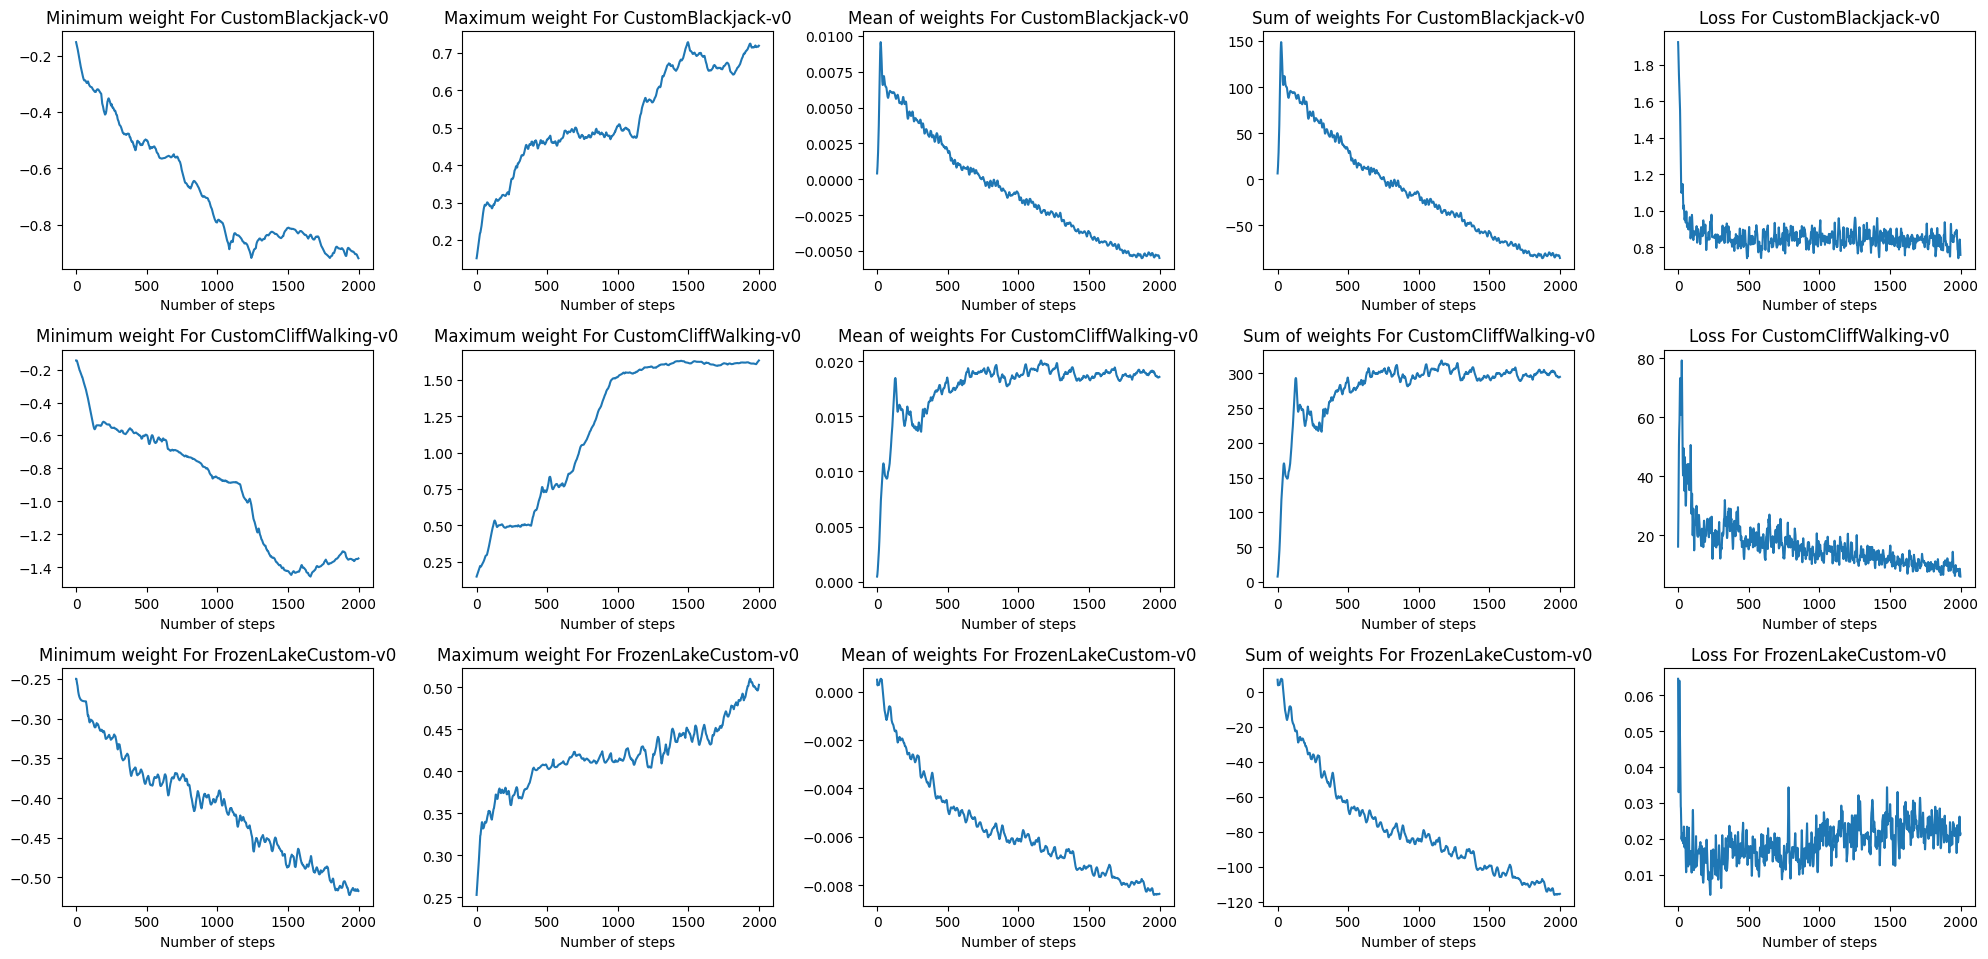

In [19]:
import matplotlib.pyplot as plt
import numpy as np
def plot_3x5_subplots(results, labels=None):
    """
    Plot a 3x5 grid of subplots using data from a 3D array.

    Parameters:
    - results: 3x5 list/array where results[i][j] contains (x, y1, y2, ..., yn) data for subplot[i][j]
    - titles: Optional 3x5 list of titles for each subplot
    - labels: Optional list of labels for each line in the plots (used in legends per column)
    """

    fig, axes = plt.subplots(3, 5, figsize=(20, 10), sharex=False, sharey=False)

    for i in range(3):
        data = results[i]
        data = np.array(data).T
        for j in range(5):
            ax = axes[i][j]
            if j == 4:
                data[j] = smooth_curve(data[j])
            ax.plot(data[j], label=labels[j])

            title = labels[j] + " For " + envs_names[i]
            ax.set_title(title)
            ax.set_xlabel("Number of steps")


    # # Add shared legends per column
    # for j in range(5):
    #     handles, legend_labels = axes[0][j].get_legend_handles_labels()
    #     if handles:
    #         fig.legend(handles, legend_labels, loc='upper center', ncol=len(legend_labels), bbox_to_anchor=(0.1 + j * 0.18, 1.03))

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Line labels
labels = ["Minimum weight", "Maximum weight", "Mean of weights", "Sum of weights", "Loss"]

plot_3x5_subplots(results, labels)

In [20]:
import baird
import boyan
import RandomWalk

import argparse
import os

import gymnasium as gym
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

from tianshou.data import (
    Collector,
    CollectStats,
    PrioritizedVectorReplayBuffer,
    ReplayBuffer,
    VectorReplayBuffer,
)
from tianshou.env import DummyVectorEnv
from tianshou.policy.modelfree.iqn import IQNPolicy
import tianshou.policy.modelfree.iqn as iqn
from tianshou.policy.base import BasePolicy
from tianshou.trainer import OffpolicyTrainer
from tianshou.utils import TensorboardLogger
from tianshou.utils.net.common import Net
from tianshou.utils.net.discrete import ImplicitQuantileNetwork
from tianshou.utils.space_info import SpaceInfo

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
env = gym.make("Blackjack-v1")